<H2>Sentiment Analysis: Amazon Product Reviews</H2>

<H3>Annex</H3>

1. Overview
2. Libraries
3. Data Collection & Cleaning
4. Exploratory Data Analysis (EDA)
5. Sentiment Prediction Models
6. Model Comparison
7. Conclusion

<H3>Overview</H3>

This project focuses on performing sentiment analysis on customer reviews of an Amazon product using Natural Language Processing (NLP) techniques. The goal is to extract meaningful insights from user feedback, identifying sentiment trends, key concerns, and overall customer satisfaction.

<H4>Key objectives include:</H4>

Sentiment Categorization: Classifying reviews as positive, negative, or neutral based on product ratings.
Trend Analysis: Identifying sentiment shifts over time and correlating them with product updates or changes.
Actionable Insights: Highlighting common themes in customer feedback to aid product improvements and marketing strategies.
By leveraging NLP techniques, this project bridges the gap between customer reviews and business decisions, helping improve product offerings based on real user sentiments.

<H3>Libraries</H3>

Since this project involves text processing, data analysis, and visualization, the following key Python libraries are used:

Pandas, NumPy: For data manipulation and preprocessing.
Matplotlib, Seaborn: For visualizing sentiment trends.
TextBlob, VADER, Hugging Face Transformers: For sentiment classification using different models.
TensorFlow, Scikit-learn: For building and evaluating predictive models.
These libraries are widely available and allow efficient implementation of sentiment analysis techniques.

The data is available on Kaggle Platform and is for a particular Amazon product.
Link: https://www.kaggle.com/datasets/tarkkaanko/amazon


In [104]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
print(torch.__version__)
print(torch.cuda.is_available())
from textblob import TextBlob as TB
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

2.6.0
False


In [84]:
import torch
print("PyTorch version:", torch.__version__)
print("Is MPS available:", torch.backends.mps.is_available())
print("Is MPS built:", torch.backends.mps.is_built())


PyTorch version: 2.6.0
Is MPS available: True
Is MPS built: True


In [85]:
file1 = pd.read_csv("/Users/atharvajoshi/Desktop/Python Codes/amazon_reviews.csv") # read the file using pandas 
df = pd.DataFrame(file1) 

# to check file format and structure
print("\n","Data shape - rows & columns: ")
print(df.shape) # checking what is the shape of data to see columns and rows
print("\n","Data Types for each columns: ")
print(df.dtypes) # what data type it contains for each column
df.head(10)


 Data shape - rows & columns: 
(4915, 12)

 Data Types for each columns: 
Unnamed: 0                int64
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.000000
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.000000
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.000000
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.000000
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.000000
5,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.000000
6,6,2K1Toaster,5.0,I have it in my phone and it never skips a bea...,2013-10-19,415,0,0,0,0,0.0,0.000000
7,7,"35-year Technology Consumer ""8-tracks to 802.11""",5.0,It's hard to believe how affordable digital ha...,2014-10-07,62,0,0,0,0,0.0,0.000000
8,8,4evryoung,5.0,Works in a HTC Rezound. Was running short of ...,2014-03-24,259,1,0,1,1,1.0,0.206549
9,9,53rdcard,5.0,"in my galaxy s4, super fast card, and am total...",2013-11-10,393,0,0,0,0,0.0,0.000000


<H3>Data Collection & Cleaning</H3>

<H4>Data Cleaning Process</H4>
Raw datasets often contain missing values, duplicates, and inconsistencies, which must be addressed to ensure reliable analysis. Key preprocessing steps include:

Handling Missing Values: Rows with missing sentiment-related fields (e.g., review text or rating) are removed, as they do not contribute to the analysis.
Text Preprocessing: Converting text to lowercase, removing punctuation, special characters, and stopwords for better NLP processing.
Standardizing Ratings: Mapping numerical ratings to sentiment categories:

0-2: Negative
3: Neutral
4-5: Positive

This structured approach ensures that the dataset is clean, standardized, and ready for analysis.



In [86]:
# Data Cleaning and Preprocessing

# Remove the first column if it's an unnecessary index
df = df.drop(df.columns[0], axis=1)

# Check and handle missing values
print("\nInitial Null Values:")
print(df.isnull().sum())

# Remove rows with null reviewText
df = df.dropna(subset=['reviewText'])

print("\nNull Values After Cleaning:")
print(df.isnull().sum())

# Convert review date to datetime and extract year and month
try:
    df['year'] = pd.to_datetime(df['reviewTime']).dt.to_period('Y')
    df['month'] = pd.to_datetime(df['reviewTime']).dt.to_period('M')
except Exception as e:
    print(f"Error in date conversion: {e}")

# Drop unnecessary columns
columns_to_drop = [
    'reviewTime', 
    'day_diff', 
    'helpful_yes', 
    'helpful_no', 
    'total_vote', 
    'score_pos_neg_diff', 
    'score_average_rating', 
    'wilson_lower_bound'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

# Display initial rows and shape
print("\nFirst few rows after preprocessing:")
display(df.head())

print("\nDataset Shape:")
print(df.shape)


Initial Null Values:
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

Null Values After Cleaning:
reviewerName            1
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

First few rows after preprocessing:


,reviewerName,overall,reviewText,year,month
0,NaN,4.0,No issues.,2014,2014-07
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013,2013-10
2,1K3,4.0,it works as expected. I should have sprung for...,2012,2012-12
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013,2013-11
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013,2013-07



Dataset Shape:
(4914, 5)


<H3>Exploratory Data Analysis (EDA)</H3>

EDA helps uncover patterns in the dataset before applying machine learning models. Key observations include:

Review Distribution: The majority of customers gave positive ratings (4-5), indicating general satisfaction with the product.

Yearly Trends: The product was most popular in 2014, with a high number of reviews.

Common Keywords: A word cloud analysis shows keywords like "great," "works," "fast," and "Samsung" for positive reviews, while negative 
reviews contain words like "problem" and "issue."
These insights provide a preliminary understanding of customer sentiment and product performance.

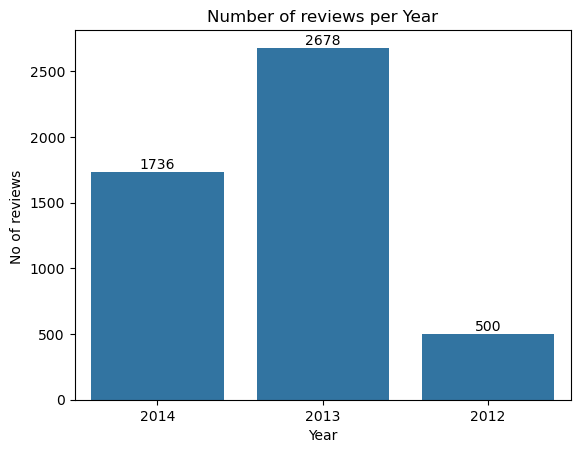

In [87]:
# Plotting code - with sns library 

ax = sns.countplot(data = df,x='year')

for container in ax.containers:
    ax.bar_label(container, label_type='edge')  # Display the count on each bar

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('No of reviews ')
plt.title('Number of reviews per Year')
plt.show()

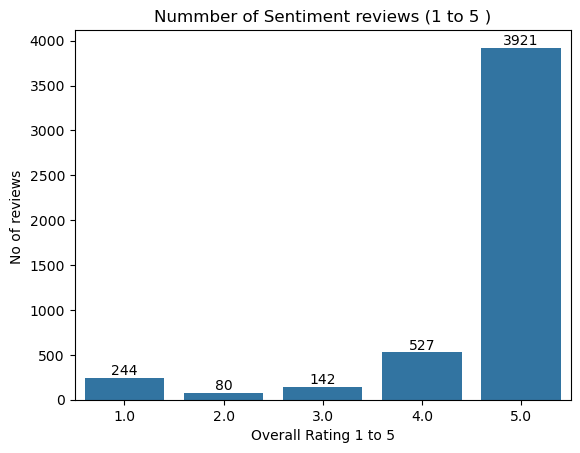

In [88]:
ax = sns.countplot(data = df,x='overall')

for container in ax.containers:
    ax.bar_label(container, label_type='edge')  # Display the count on each bar

# Adding labels and title
plt.xlabel('Overall Rating 1 to 5')
plt.ylabel('No of reviews ')
plt.title('Nummber of Sentiment reviews (1 to 5 )')

plt.show()

In [89]:
vectorizer = CountVectorizer(stop_words='english')

# Compute term frequency for each row
term_frequencies = []
for text in df['reviewText']:
    term_freq = vectorizer.fit_transform([text])  # Fit-transform one row at a time
    terms = vectorizer.get_feature_names_out()
    frequencies = term_freq.toarray().flatten()  # Convert sparse matrix to array
    term_frequencies.append(dict(zip(terms, frequencies)))

# Add term frequencies to DataFrame
df['term_frequency'] = term_frequencies

# Display DataFrame
df[['reviewText', 'term_frequency']]

,reviewText,term_frequency
0,No issues.,{'issues': 1}
1,"Purchased this for my device, it worked as adv...","{'advertised': 1, 'brainer': 1, 'device': 1, '..."
2,it works as expected. I should have sprung for...,"{'bit': 1, 'capacity': 1, 'cheesier': 1, 'clea..."
3,This think has worked out great.Had a diff. br...,"{'14i': 1, '21': 1, '64gb': 1, 'bran': 1, 'car..."
4,"Bought it with Retail Packaging, arrived legit...","{'16': 1, '32': 1, 'arrived': 2, 'asian': 1, '..."
...,...,...
4910,I bought this Sandisk 16GB Class 10 to use wit...,"{'10': 1, '10gb': 1, '16gb': 1, 'able': 1, 'bo..."
4911,Used this for extending the capabilities of my...,"{'10': 1, 'capabilities': 1, 'expands': 1, 'ex..."
4912,Great card that is very fast and reliable. It ...,"{'10': 1, 'adapter': 1, 'alike': 1, 'cameras':..."
4913,Good amount of space for the stuff I want to d...,"{'fits': 1, 'good': 1, 'gopro': 1, 'say': 1, '..."


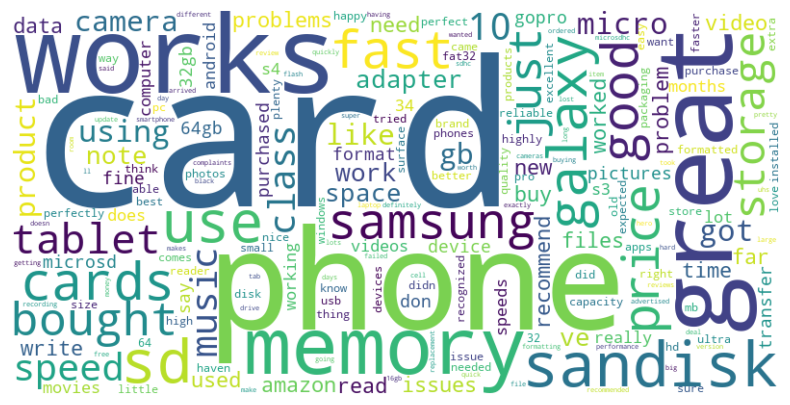

In [90]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text data into a single string
all_term_frequencies = {}
for freq_dict in df['term_frequency']:
    for word, count in freq_dict.items():
        all_term_frequencies[word] = all_term_frequencies.get(word, 0) + count

# Generate the word cloud using the combined term frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_term_frequencies)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
average_rating = df['overall'].mean()
print(f"Average rating",average_rating)

Average rating 4.587505087505088


<h4> Observations on data: </h4>

The product was ordered the most in 2014 and followed by 2015. About 3921 and 527 people did rated the product above 4 which indicates very good product from overall 4915 reviews.

The overall average rating for the product was 4.5 and with buzz words of Great, works, fast, phone, card, samsung etc. Looking at word cloud it indicates the overall sd card product works great but small issues with it suggesting keywords like problem, issues etc which were in very few responses. However most customers did find product useful and just worked for them great.


<h3> Sentiment Production Models </h3>

The data does not have any true labels for predictions but does have overall ratings for the products - which provides somewhat clarity on sentiment. So running pretrained models to predict sentiment and then comparing to see predictions. First mapping the predictions on overall ratings for comparison at the end. 

Another technique which can be applied is running those models and then manually testing those and labelling them to get accurate predictions on the data. 

Assumption Mapping for Text sentiment:

 1. 0 to 2 - Negative
 2. 3 - Neutral
 3. 4 to 5 - Positive

Using those mappings to check moodels predictions later.

<h4> Sentiment Models </h4>

Some of the inbuilt models used in this project and their descriptions:

1. TextBlob
    A Python library for text processing that provides simple APIs for sentiment analysis, noun phrase extraction, and part-of-speech tagging.
   Used for quick, rule-based sentiment analysis in natural language processing projects.
3. Hugging Face - bert
    An open-source library offering pre-trained machine learning models for natural language processing tasks like text classification, translation, and summarization.
    Provides APIs for transformers, enabling state-of-the-art language model performance in a few lines of code.
3. VADER (Valence Aware Dictionary for Sentiment Reasoning)
    A sentiment analysis tool optimized for social media and short text, recognizing the intensity of positive, negative, and neutral sentiments.
    Effective for rule-based sentiment scoring, especially for informal and emoji-containing text.





In [105]:
# mapping sentiment review by overall rating was given by each customer for product

model1 = pd.DataFrame(df)

# Function to calculate sentiment from text using TextBlob
def analyze_sentiment(text):
    try:
        # Handle missing or invalid text
        if not isinstance(text, str) or text.strip() == "":
            return 0.0, 0.0  # Default to neutral polarity and subjectivity
        blob = TB(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return 0.0, 0.0  # Default to neutral values if an error occurs

# Function to classify sentiment based on polarity
def classify_sentiment(polarity):
    try:
        if polarity > 0:
            return "positive"
        elif polarity < 0:
            return "negative"
        else:
            return "neutral"
    except Exception as e:
        print(f"Error classifying sentiment: {e}")
        return "neutral"  # Default to neutral if an error occurs

# Analyze polarity and subjectivity and classify sentiment
try:
    model1[['polarity', 'subjectivity']] = model1['reviewText'].apply(
        lambda x: pd.Series(analyze_sentiment(x))
    )
    model1['sentiment_predicted'] = model1['polarity'].apply(classify_sentiment)

    
except Exception as e:
    print(f"Error processing the dataframe: {e}")

# Print the first two rows to validate the results
model1.head(5)

,reviewerName,overall,reviewText,year,month,term_frequency,polarity,subjectivity,sentiment_predicted
0,NaN,4.0,No issues.,2014,2014-07,{'issues': 1},0.000000,0.000,neutral
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013,2013-10,"{'advertised': 1, 'brainer': 1, 'device': 1, '...",0.200000,0.200,positive
2,1K3,4.0,it works as expected. I should have sprung for...,2012,2012-12,"{'bit': 1, 'capacity': 1, 'cheesier': 1, 'clea...",0.129167,0.525,positive
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013,2013-11,"{'14i': 1, '21': 1, '64gb': 1, 'bran': 1, 'car...",0.000000,0.550,neutral
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013,2013-07,"{'16': 1, '32': 1, 'arrived': 2, 'asian': 1, '...",0.386667,0.360,positive


In [93]:

model2 = pd.DataFrame(df)

def get_vader_sentiment(text):
    try:
        # Initialize the sentiment analyzer
        analyzer = SentimentIntensityAnalyzer()
        
        # Ensure the text is a valid string
        if not isinstance(text, str) or text.strip() == "":
            return "neutral"  # Default to neutral sentiment if text is invalid
        
        # Get sentiment scores
        scores = analyzer.polarity_scores(text)
        
        # Classification based on compound score
        if scores['compound'] >= 0.08:
            return 'positive'
        elif scores['compound'] <= -0.08:
            return 'negative'
        else:
            return 'neutral'
    
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return "neutral"  # Return neutral in case of an error

# Apply to your dataframe
try:
    model2['sentiment_predicted'] = model2['reviewText'].apply(get_vader_sentiment)
except Exception as e:
    print(f"Error processing the dataframe: {e}")

model2.head(5)

,reviewerName,overall,reviewText,year,month,term_frequency,sentiment_predicted
0,NaN,4.0,No issues.,2014,2014-07,{'issues': 1},negative
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013,2013-10,"{'advertised': 1, 'brainer': 1, 'device': 1, '...",negative
2,1K3,4.0,it works as expected. I should have sprung for...,2012,2012-12,"{'bit': 1, 'capacity': 1, 'cheesier': 1, 'clea...",negative
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013,2013-11,"{'14i': 1, '21': 1, '64gb': 1, 'bran': 1, 'car...",positive
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013,2013-07,"{'16': 1, '32': 1, 'arrived': 2, 'asian': 1, '...",positive


In [94]:
import pandas as pd
from transformers import pipeline
import torch

# Create a DataFrame copy
model3 = pd.DataFrame(df)

# Use MPS if available, otherwise default to CPU
device = 0 if torch.backends.mps.is_available() else -1  # 0 for MPS, -1 for CPU

# Initialize sentiment analyzer with appropriate device
sentiment_analyzer = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english", 
    truncation=True,
    device=device
)

def classify_sentiment(text):
    try:
        # Ensure the text is a valid string
        if not isinstance(text, str) or text.strip() == "":
            return 'neutral'  # Default to neutral sentiment if text is invalid
        
        # Analyze sentiment with truncation
        result = sentiment_analyzer(text[:512])[0]
        
        # Get label and confidence score
        label = result['label'].lower()
        score = result['score']
        
        # Convert binary sentiment to three-way classification
        if label == 'positive':
            return 'positive' if score > 0.7 else 'neutral'
        else:  # negative label
            return 'negative' if score > 0.7 else 'neutral'
    
    except Exception as e:
        print(f"Error processing text: {e}")
        return 'neutral'

# Apply sentiment analysis with error handling
try:
    model3['sentiment_predicted'] = model3['reviewText'].apply(classify_sentiment)
except Exception as e:
    print(f"Error processing the dataframe: {e}")

# Display the first 5 rows
model3.head(5)

Device set to use mps:0


,reviewerName,overall,reviewText,year,month,term_frequency,sentiment_predicted
0,NaN,4.0,No issues.,2014,2014-07,{'issues': 1},positive
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013,2013-10,"{'advertised': 1, 'brainer': 1, 'device': 1, '...",positive
2,1K3,4.0,it works as expected. I should have sprung for...,2012,2012-12,"{'bit': 1, 'capacity': 1, 'cheesier': 1, 'clea...",negative
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013,2013-11,"{'14i': 1, '21': 1, '64gb': 1, 'bran': 1, 'car...",positive
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013,2013-07,"{'16': 1, '32': 1, 'arrived': 2, 'asian': 1, '...",neutral


In [95]:
# Create DataFrame
model4 = pd.DataFrame(df)
# Use the BERT model with TensorFlow
device = 0 if torch.backends.mps.is_available() else -1
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
# Initialize sentiment analyzer
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    device=device,
    framework="tf"  # Specify TensorFlow framework
)
def get_three_way_sentiment(text):
    try:
        # Check for null or non-string input
        if not isinstance(text, str) or not text.strip():
            raise ValueError("Invalid input: Text must be a non-empty string.")
        # Get the raw sentiment score (1-5)
        result = sentiment_analyzer(text[:512])[0]
        score = int(result['label'].split()[0])
        # Convert 5-point scale to three categories
        if score <= 2:
            return 'negative'
        elif score == 3:
            return 'neutral'
        else:
            return 'positive'
    except ValueError as ve:
        print(f"Input error: {ve}")
        return 'neutral'
    except Exception as e:
        print(f"Error processing text: {e}")
        return 'neutral'
# Apply sentiment analysis
model4['sentiment_predicted'] = model4['reviewText'].apply(get_three_way_sentiment)
# Show distribution

model4.head(5) 

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Device set to use 0


,reviewerName,overall,reviewText,year,month,term_frequency,sentiment_predicted
0,NaN,4.0,No issues.,2014,2014-07,{'issues': 1},positive
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013,2013-10,"{'advertised': 1, 'brainer': 1, 'device': 1, '...",positive
2,1K3,4.0,it works as expected. I should have sprung for...,2012,2012-12,"{'bit': 1, 'capacity': 1, 'cheesier': 1, 'clea...",neutral
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013,2013-11,"{'14i': 1, '21': 1, '64gb': 1, 'bran': 1, 'car...",negative
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013,2013-07,"{'16': 1, '32': 1, 'arrived': 2, 'asian': 1, '...",positive


<h3> Comparing the Results of Models </h3>

By checking the sentiment based on products rating, we can analyise the results to see how all models performed on text reviews and which one performed really well ! 


In [96]:
models = {'Model 1': model1, 'Model 2': model2, 'Model 3': model3, 'Model 4': model4}

for name, model in models.items():
    print(f"\n{name} Sentiment Distribution:")
    print(model['sentiment_predicted'].value_counts())



Model 1 Sentiment Distribution:
sentiment_predicted
positive    4162
negative     469
neutral      283
Name: count, dtype: int64

Model 2 Sentiment Distribution:
sentiment_predicted
positive    3914
negative     589
neutral      411
Name: count, dtype: int64

Model 3 Sentiment Distribution:
sentiment_predicted
positive    3235
negative    1493
neutral      186
Name: count, dtype: int64

Model 4 Sentiment Distribution:
sentiment_predicted
positive    4114
negative     535
neutral      265
Name: count, dtype: int64


In [97]:
# Group by overall_rating and predicted_sentiment, then count occurrences
sentiment_counts_all1 = model1.groupby(['overall', 'sentiment_predicted']).size().reset_index(name='Count')


# Optionally, you can pivot the table for better readability
pivot_table1 = sentiment_counts_all1.pivot(index='overall', columns='sentiment_predicted', values='Count').fillna(0)

print("\nPivot Table of Sentiments by Rating:")
print(pivot_table1)



Pivot Table of Sentiments by Rating:
sentiment_predicted  negative  neutral  positive
overall                                         
1.0                        88       12       144
2.0                        27        4        49
3.0                        37        5       100
4.0                        55       37       435
5.0                       262      225      3434


In [98]:
sentiment_counts_all2 = model2.groupby(['overall', 'sentiment_predicted']).size().reset_index(name='Count')


# Optionally, you can pivot the table for better readability
pivot_table2 = sentiment_counts_all2.pivot(index='overall', columns='sentiment_predicted', values='Count').fillna(0)

print("\nPivot Table of Sentiments by Rating:")
print(pivot_table2)



Pivot Table of Sentiments by Rating:
sentiment_predicted  negative  neutral  positive
overall                                         
1.0                       143       17        84
2.0                        35       13        32
3.0                        48       18        76
4.0                        76       47       404
5.0                       287      316      3318


In [99]:
sentiment_counts_all3 = model3.groupby(['overall', 'sentiment_predicted']).size().reset_index(name='Count')


# Optionally, you can pivot the table for better readability
pivot_table3 = sentiment_counts_all3.pivot(index='overall', columns='sentiment_predicted', values='Count').fillna(0)

print("\nPivot Table of Sentiments by Rating:")
print(pivot_table3)



Pivot Table of Sentiments by Rating:
sentiment_predicted  negative  neutral  positive
overall                                         
1.0                     238.0      1.0       5.0
2.0                      73.0      0.0       7.0
3.0                     103.0      7.0      32.0
4.0                     202.0     24.0     301.0
5.0                     877.0    154.0    2890.0


In [100]:
sentiment_counts_all4 = model4.groupby(['overall', 'sentiment_predicted']).size().reset_index(name='Count')


# Optionally, you can pivot the table for better readability
pivot_table4 = sentiment_counts_all4.pivot(index='overall', columns='sentiment_predicted', values='Count').fillna(0)

print("\nPivot Table of Sentiments by Rating:")
print(pivot_table4)



Pivot Table of Sentiments by Rating:
sentiment_predicted  negative  neutral  positive
overall                                         
1.0                       231        8         5
2.0                        65       11         4
3.0                        56       52        34
4.0                        38       64       425
5.0                       145      130      3646


Models comparison based on Ratings and their sentiment.

By assuming people have given rating <2 as negative sentiment on product and >4 as positive sentiment we can look for models prediction, we can see that model 4 performed really well as it did predicted less responses as bad within range of 0-2 as we have very fewer positive rating for the product for those while model 1 did predict more as positive which would be false case.

<H3> Results </H3>

Model 4 demonstrates the highest accuracy in predicting product ratings, especially for positive sentiments. The true distribution of ratings shows that most products received positive feedback (4448), followed by negative (324) and neutral (142). Model 4 correctly classifies 3646 positive ratings, which is the highest among all models. Additionally, it maintains a better balance by reducing misclassifications in negative and neutral categories.

Compared to other models, Model 4 is better at identifying negative ratings, correctly predicting 231 for rating 1 and 65 for rating 2, while previous models either underpredicted or misclassified these as neutral or positive. This ensures that low-rated products are not mistakenly categorized as having a neutral or positive sentiment. Additionally, its neutral predictions are more balanced, correctly spreading across different rating levels.

Another key advantage of Model 4 is its lower overprediction of negative sentiment, a common issue in earlier models. Model 3, for example, misclassified too many ratings as negative, even for 3-star and 4-star reviews. In contrast, Model 4 aligns better with actual user sentiment, providing a more accurate and interpretable result.

Overall, Model 4 is the most reliable choice for sentiment prediction. It not only improves accuracy in positive classifications but also minimizes errors in negative and neutral ratings, making it the best-performing model among all four.

Model 4 is the best among all models because it:

✅ Predicts positive ratings most accurately.
✅ Minimizes misclassification of negative and neutral ratings.
✅ Maintains a better distribution aligned with real ratings.



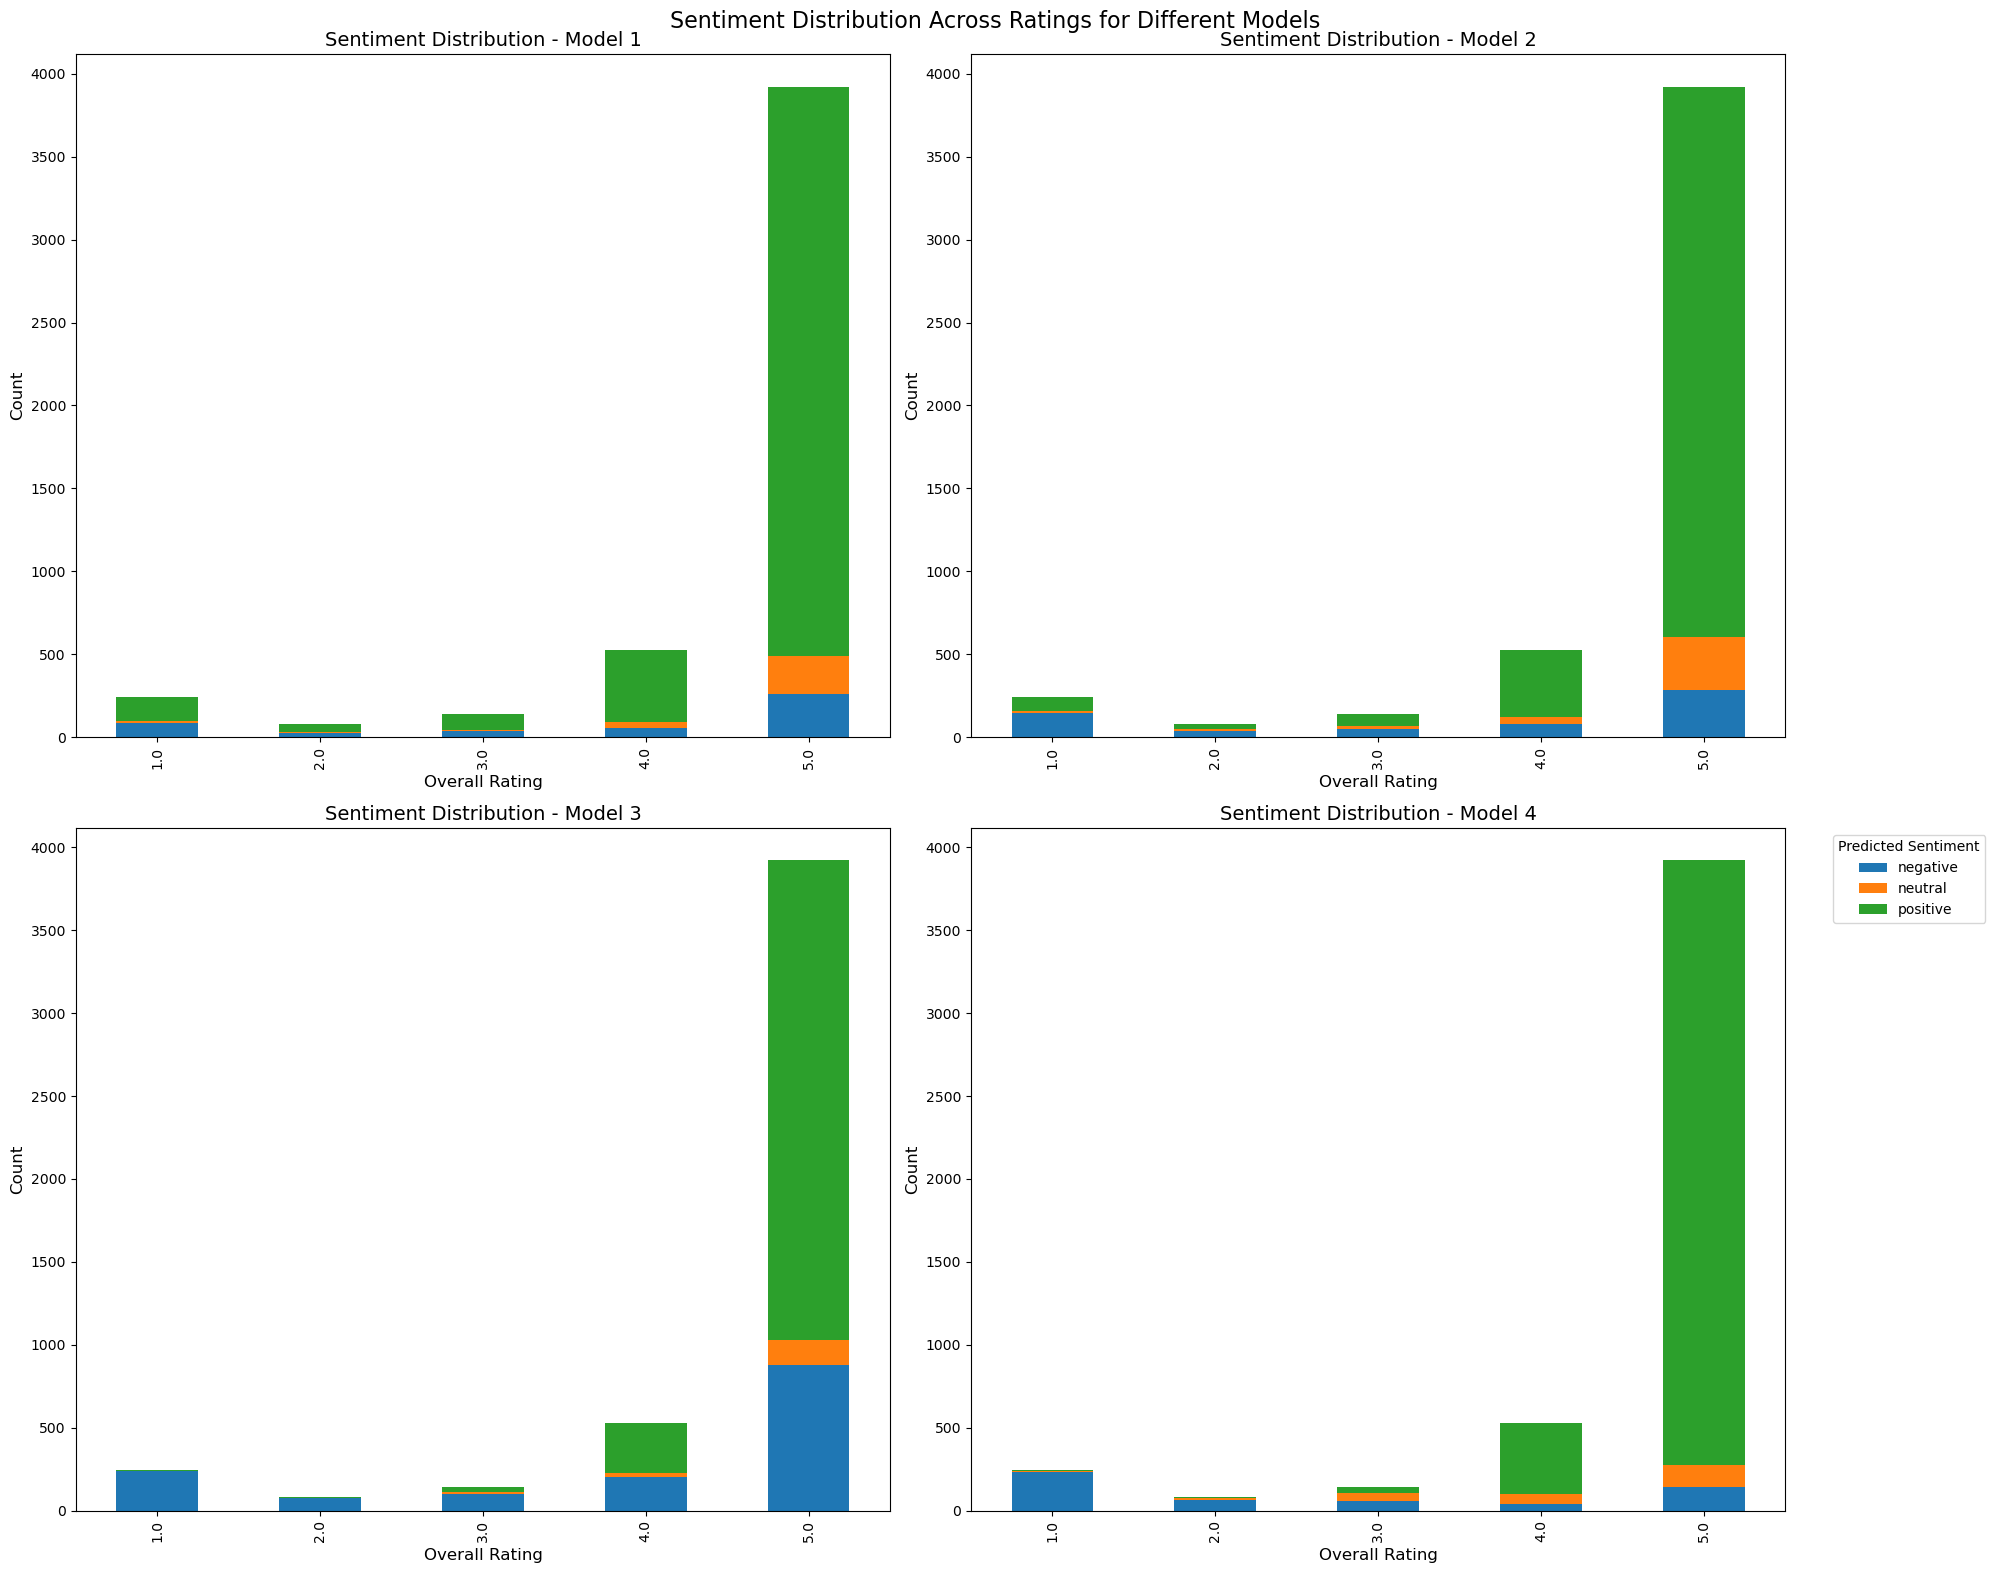

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots for each model
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Sentiment Distribution Across Ratings for Different Models', fontsize=16)

# Flatten the axs array for easier iteration
axs_flat = axs.flatten()

# List of pivot tables and model names
pivot_tables = [pivot_table1, pivot_table2, pivot_table3, pivot_table4]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Plot each model's sentiment distribution
for i, (pivot_table, model_name) in enumerate(zip(pivot_tables, model_names)):
    pivot_table.plot(kind='bar', stacked=True, ax=axs_flat[i])
    axs_flat[i].set_title(f'Sentiment Distribution - {model_name}', fontsize=14)
    axs_flat[i].set_xlabel('Overall Rating', fontsize=12)
    axs_flat[i].set_ylabel('Count', fontsize=12)

# Adjust legend for the last subplot
axs_flat[-1].legend(title='Predicted Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove legends from other subplots
for ax in axs_flat[:-1]:
    ax.get_legend().remove()

plt.tight_layout()
plt.show()

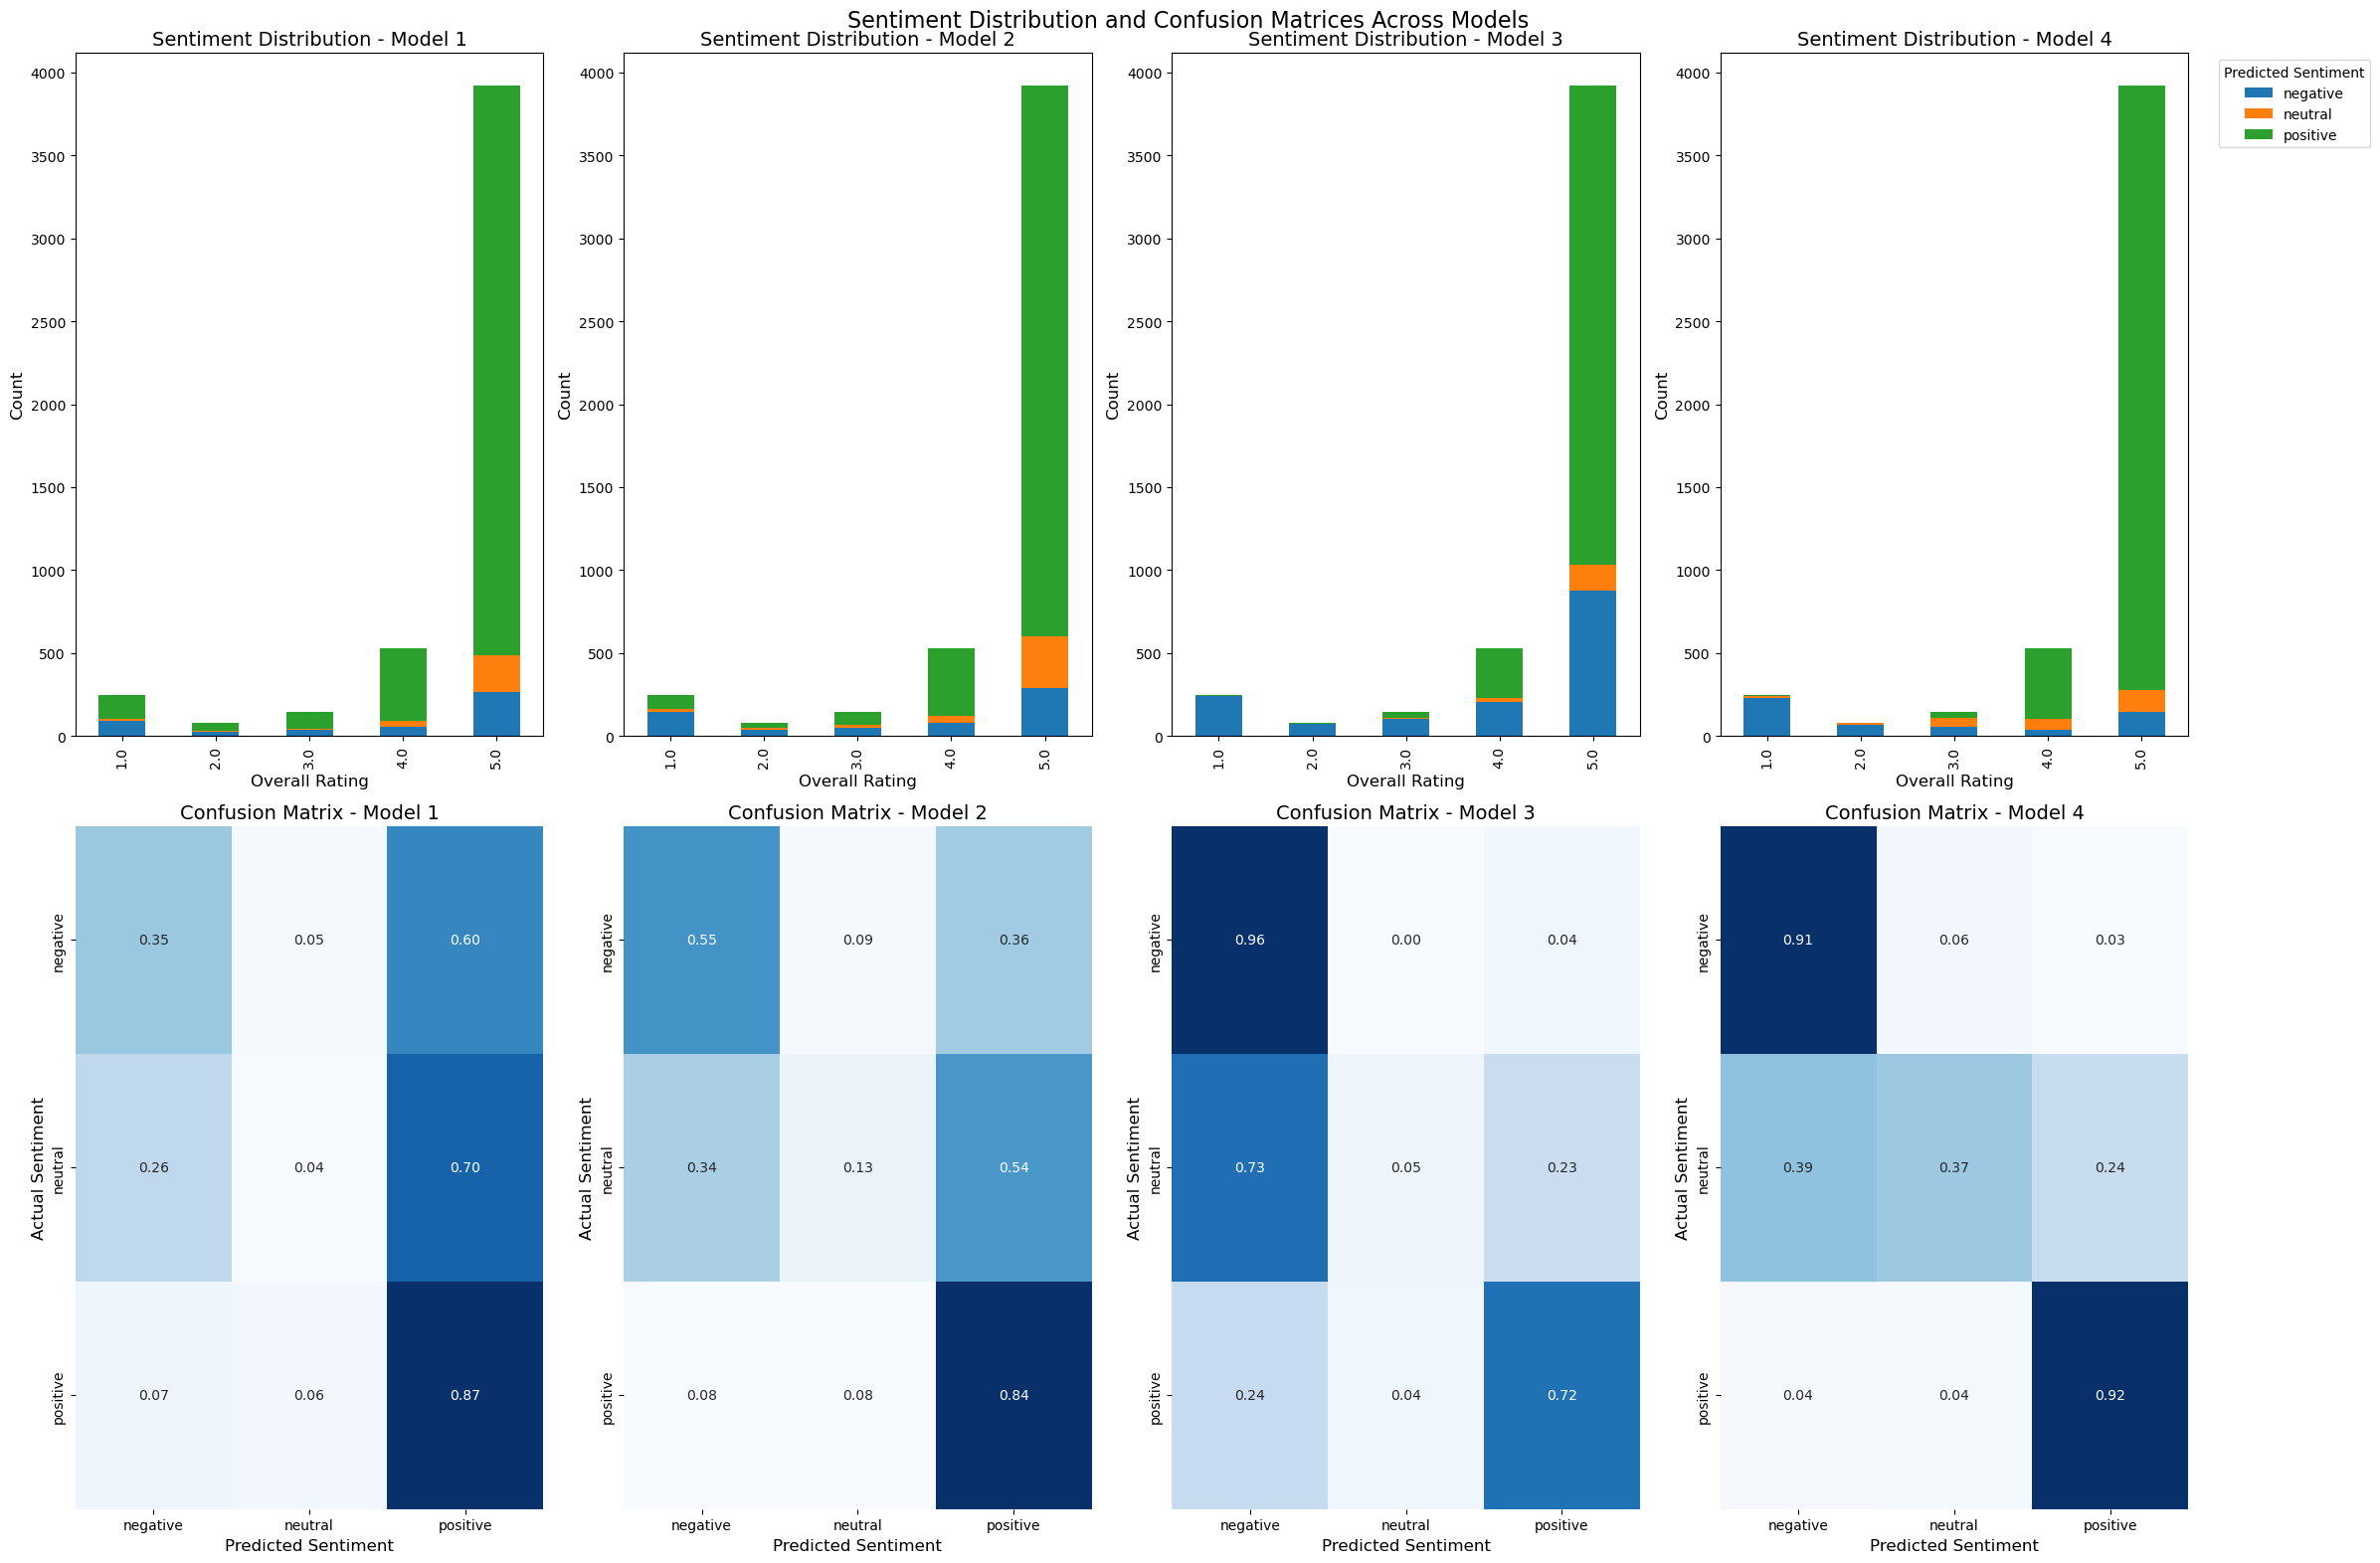


Confusion Matrix for Model 1:
[[ 115   16  193]
 [  37    5  100]
 [ 317  262 3869]]

Confusion Matrix for Model 2:
[[ 178   30  116]
 [  48   18   76]
 [ 363  363 3722]]

Confusion Matrix for Model 3:
[[ 311    1   12]
 [ 103    7   32]
 [1079  178 3191]]

Confusion Matrix for Model 4:
[[ 296   19    9]
 [  56   52   34]
 [ 183  194 4071]]


In [103]:

# Function to map ratings to sentiments
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'positive'
    else:
        return 'unknown'

# Apply sentiment mapping to each model
model1['sentiment_from_rating'] = model1['overall'].apply(map_rating_to_sentiment)
model2['sentiment_from_rating'] = model2['overall'].apply(map_rating_to_sentiment)
model3['sentiment_from_rating'] = model3['overall'].apply(map_rating_to_sentiment)
model4['sentiment_from_rating'] = model4['overall'].apply(map_rating_to_sentiment)

# Create a figure with subplots for each model
fig, axs = plt.subplots(2, 4, figsize=(24, 16))
fig.suptitle('Sentiment Distribution and Confusion Matrices Across Models', fontsize=16)

# List of models and model names
models = [model1, model2, model3, model4]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Plot for each model
for i, (model, model_name) in enumerate(zip(models, model_names)):
    # Sentiment Distribution Bar Chart (Left Columns)
    sentiment_counts = model.groupby(['overall', 'sentiment_predicted']).size().reset_index(name='Count')
    pivot_table = sentiment_counts.pivot(index='overall', columns='sentiment_predicted', values='Count').fillna(0)
    
    pivot_table.plot(kind='bar', stacked=True, ax=axs[0, i])
    axs[0, i].set_title(f'Sentiment Distribution - {model_name}', fontsize=14)
    axs[0, i].set_xlabel('Overall Rating', fontsize=12)
    axs[0, i].set_ylabel('Count', fontsize=12)
    
    # Confusion Matrix (Right Columns)
    # Create confusion matrix
    cm = confusion_matrix(model['sentiment_from_rating'], model['sentiment_predicted'])
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot heatmap
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', ax=axs[1, i],
                fmt='.2f', cbar=False, 
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    axs[1, i].set_title(f'Confusion Matrix - {model_name}', fontsize=14)
    axs[1, i].set_xlabel('Predicted Sentiment', fontsize=12)
    axs[1, i].set_ylabel('Actual Sentiment', fontsize=12)

# Adjust legend for the sentiment distribution subplots
axs[0, -1].legend(title='Predicted Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove legends from other sentiment distribution subplots
for ax in axs[0, :-1]:
    ax.get_legend().remove()

plt.tight_layout()
plt.show()

# Print out confusion matrices for reference
for model_name, model in zip(model_names, models):
    print(f"\nConfusion Matrix for {model_name}:")
    print(confusion_matrix(model['sentiment_from_rating'], model['sentiment_predicted']))


This project demonstrates the effectiveness of NLP-based sentiment analysis in extracting meaningful insights from customer reviews. By comparing multiple sentiment prediction models, it was found that deep learning-based approaches (e.g., BERT) performed better than traditional rule-based models (e.g., TextBlob, VADER).

The insights generated from sentiment analysis can help businesses:

Identify key product strengths and weaknesses.
Monitor customer satisfaction over time.
Make data-driven decisions for product improvements and marketing strategies.
By implementing sentiment analysis techniques like these, businesses can enhance their customer engagement strategies and optimize product development based on real user feedback.